In [72]:
# Importing the required libraries
import os
import numpy as np

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

import librosa
import soundfile as sf
import scipy.io.wavfile as wav
import wave
from pydub import AudioSegment

In [73]:
# Read the CSV file into a pandas dataframe
df = pd.read_csv('rain_files.csv')
# Display the first few rows of the dataframe
df.head()

,timestamp,filename,rain,rain_class,total_rain
0,2023-02-14 10:05:00,SMM00894_20230214_100500.wav,0,no rain,0.0
1,2023-02-14 10:10:00,SMM00894_20230214_101011.wav,0,no rain,0.0
2,2023-02-14 10:15:00,SMM00894_20230214_101500.wav,0,no rain,0.0
3,2023-02-14 10:20:00,SMM00894_20230214_102000.wav,0,no rain,0.0
4,2023-02-14 10:25:00,SMM00894_20230214_102500.wav,0,no rain,0.0


In [74]:
df.describe()

,rain,total_rain
count,36475.000000,36475.000000
mean,0.035723,0.035065
std,0.185601,0.339829
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1.000000,16.800000


[0.18206458 0.14869685 0.10823784 0.06162928 0.05262784 0.05029361
 0.04936676 0.04705344 0.04485972 0.03907133 0.03620299 0.03505862
 0.03119725 0.02748413 0.02201338 0.01703711 0.01360647 0.01270977
 0.01141162 0.00937745]
components
 (5628, 10)


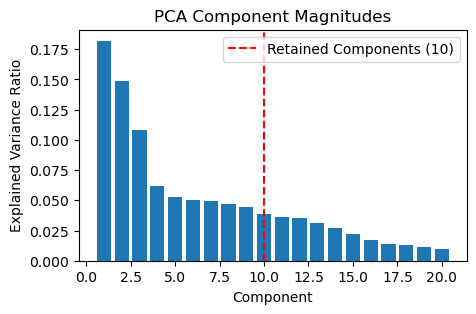

[[ 2.19432068e+01  1.47406158e+01 -2.43250732e+01 ...  2.05256653e+00
   1.24140759e+01 -1.22983227e+01]
 [ 1.53153992e+01  1.11621552e+01  3.88859558e+00 ... -2.93078995e+00
   4.34894943e+00 -2.94762492e+00]
 [ 1.65367661e+01  1.10372162e+01  8.22541809e+00 ... -3.26294327e+00
   2.60788536e+00  1.04229164e+00]
 ...
 [-1.84671707e+01  1.55280075e+01  2.29728699e+00 ...  3.94439697e-03
   8.06037331e+00 -6.76216602e+00]
 [-1.68139954e+01  1.31349182e+01  2.16532898e+00 ... -8.66119385e-01
   9.60290527e+00 -9.02440071e-01]
 [-1.76507874e+01  8.75756836e+00 -1.64703369e-01 ... -9.35150146e+00
   6.69951248e+00 -3.26584029e+00]]
[[-353.20979751  -33.89097794  -92.30192566 ...   -1.17253899
     2.15275533    9.63731816]
 [-328.31093025  -19.57247607  -87.83165401 ...    2.99061046
    -4.41756464    9.5932391 ]
 [-325.09501888  -17.57465497  -89.64493228 ...    3.51028179
    -6.69392038    9.43704377]
 ...
 [-320.63207589  -26.3027335   -79.48219129 ...    9.29654594
    -6.22374028   

ParameterError: Audio buffer is not finite everywhere

In [75]:
# Sample file
file_path = r'/home/maciel/sound_of_rainfall/SMM00894_20230415_003000.wav'

def load_and_segment(file_path, segment_duration=10):
    y, sr = librosa.load(file_path, sr=None)

    # Calculate the number of segments
    num_segments = int(np.ceil(len(y) / (sr * segment_duration)))

    # Segment the audio
    segments = []
    for i in range(num_segments):
        start = i * sr * segment_duration
        end = min((i + 1) * sr * segment_duration, len(y))
        segments.append(y[start:end])

    return segments, sr

def apply_pca(segments, num_components=None):
    # Extract MFCC features
    mfcc_features = []
    for segment in segments:
        mfcc = librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=20)
        mfcc_features.append(mfcc.T)

    # Concatenate MFCC features
    data = np.concatenate(mfcc_features)

    # Apply PCA
    pca = PCA()
    components = pca.fit_transform(data)

    # Select the specified number of components based on energy
    if num_components is not None:
        explained_variance_ratio = pca.explained_variance_ratio_
        print(pca.explained_variance_ratio_)
        cumulative_variance = np.cumsum(explained_variance_ratio)
        num_components_to_keep = np.argmax(cumulative_variance >= num_components / 100) + 1
        components = components[:, :num_components_to_keep]

    return components, pca, mfcc_features

def rebuild_audio(reduced_components, pca, mfcc_features, sr):
    # Pad the reduced components with zeros to match the original shape
    num_original_components = mfcc_features[0].shape[1]
    padding = np.ones((reduced_components.shape[0], num_original_components - reduced_components.shape[1])) * 1e-3
    reduced_components_padded = np.hstack((reduced_components, padding))
    print(reduced_components)

    # Reconstruct MFCC features
    reconstructed_mfcc = pca.inverse_transform(reduced_components_padded)
    print(reconstructed_mfcc)

    
    # Invert MFCC features to obtain audio
    reconstructed_audio = librosa.feature.inverse.mfcc_to_audio(reconstructed_mfcc, sr=sr)

    return reconstructed_audio

def plot_pca_components(components, explained_variance_ratio, num_components_to_keep):
    """Plots the magnitudes of the PCA components.

    Args:
        components: A list of PCA components.
        explained_variance_ratio: The explained variance ratio of each component.
        num_components_to_keep: The number of components to keep.
    """

    plt.figure(figsize=(5, 3))
    plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio)
    plt.xlabel("Component")
    plt.ylabel("Explained Variance Ratio")
    plt.title("PCA Component Magnitudes")

    # Mark the retained components
    plt.axvline(x=num_components_to_keep, color='red', linestyle='--', label=f"Retained Components ({num_components_to_keep})")
    plt.legend()

    plt.show()

# Example usage:
segment_duration = 10
num_components = 75  # Keep 66% of the variance

# Load and segment the audio
segments, sr = load_and_segment(file_path, segment_duration)

# Apply PCA to MFCC features and get PCA object and MFCC features
components, pca, mfcc_features = apply_pca(segments, num_components)

print('components\n', components.shape)

# Plot PCA component magnitudes
explained_variance_ratio = pca.explained_variance_ratio_
num_components_to_keep = len(components[0])
plot_pca_components(components, explained_variance_ratio, num_components_to_keep)

# Rebuild the audio from reconstructed MFCC features
reconstructed_audio = rebuild_audio(components, pca, mfcc_features, sr)



"""
# Save the reconstructed audio
sf.write("/tmp/reconstructed_audio.wav", reconstructed_audio, sr)
"""

In [ ]:
?librosa.feature